In [1]:
import matplotlib.pyplot as plt
import numpy as np
import numpy.linalg as la

from src.structured_random_features.src.models.weights import V1_weights

# Packages for fft and fitting data
from scipy import fftpack as fft
from sklearn.linear_model import Lasso

# Package for importing image representation
from PIL import Image, ImageOps

from src.V1_Compress import generate_Y, compress
import pandas as pd
from dask.distributed import Client, progress
import seaborn as sns
import time
import os.path

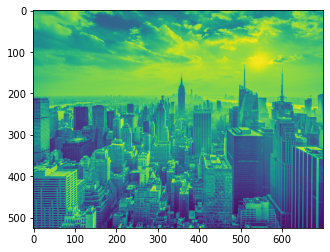

In [5]:
image_nm = 'city.png'
img = Image.open('image/' + image_nm)
img = ImageOps.grayscale(img)
img_arr = np.asarray(img)
plt.imshow(img)
orig_dim = img_arr.shape

(540, 720)
iteration 100


/home/bans/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 365420.45358364005, tolerance: 283264.5319880975
  model = cd_fast.enet_coordinate_descent(
/home/bans/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 323639.61394123296, tolerance: 182702.44718611406
  model = cd_fast.enet_coordinate_descent(


iteration 200


/home/bans/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 365749.15710386215, tolerance: 315325.6501148301
  model = cd_fast.enet_coordinate_descent(


iteration 300
iteration 400


/home/bans/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 116497.07898043455, tolerance: 83236.35867407198
  model = cd_fast.enet_coordinate_descent(
/home/bans/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 194506.05705945898, tolerance: 132274.88045902085
  model = cd_fast.enet_coordinate_descent(
/home/bans/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 144241.05334347804, tolerance: 58076.108034494144
  model = cd_fast.enet_coordinate_descent(
/home/bans/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_desc

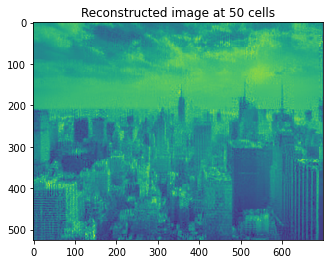

In [80]:
num_cell = 50
cell_size = 7
sparse_freq = 2
alpha = 1

alpha = 1 * 50 / num_cell

rand_weight = False
dim = img_arr.shape
n, m = dim

filter_dim = (30, 30)

filt = np.zeros(filter_dim)
filt_n, filt_m = filter_dim


# for run, num_cell in enumerate([100, 200, 300, 400, 500]):
    # Fix the V1 weights if the random_weight parameter is set to be true
if (rand_weight == True):
    W = V1_weights(num_cell, filter_dim, cell_size, sparse_freq) 

# Preprocess image and add zeros so the cols and rows would fit to the filter for any size
new_n = n + (filt_n - (n % filt_n))
new_m = m + (filt_m - (m % filt_m))

img_arr_aug = np.zeros((new_n, new_m))
img_arr_aug[:n, :m] = img_arr

print(img_arr_aug.shape)
i = 1 # counter
result = np.zeros(img_arr.shape)
cur_n, cur_m = (0, 0)
for pt in range((new_n * new_m) // (filt_n * filt_m)):
    if (i % 100 == 0) :
        print("iteration", i)
    # Randomize V1 weights for each batch if random_weight param is set to false
    if (rand_weight != True) :
        W = V1_weights(num_cell, filter_dim, cell_size, sparse_freq) 

    # keep track over height of the batches
    if (cur_m >= new_m) :
        cur_n += filt_n
        cur_m = 0

    nxt_m = cur_m + filt_m
    pt = img_arr_aug[cur_n : (cur_n + filt_n), cur_m : nxt_m]

    y = generate_Y(W, pt)
    W_model = W.reshape(num_cell, filt_n, filt_m)
    theta, reform, s = compress(W_model, y, alpha)

    img_arr_aug[cur_n : (cur_n + filt_n), cur_m : nxt_m] = reform
    cur_m = nxt_m

    i+=1

result = img_arr_aug[:n,:m]

if (run == 0) :
    # Print original image for comparison
    plt.imshow(img_arr)
    plt.title("original")
    plt.show()

plt.imshow(result)
plt.title("Reconstructed image at {cell} cells".format(cell = num_cell))
plt.show()


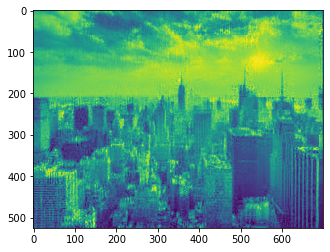

In [97]:
result[result > 255] = 255
result[result < 0] = 0
plt.imshow(result.astype(int))

In [83]:
np.max(result_aug)

255

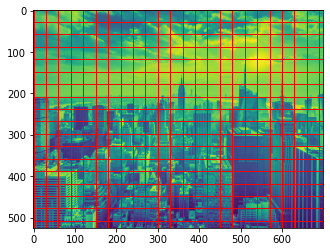

In [63]:
grid = np.zeros(img_arr.shape)
x = []
y = []
for i in range (n):
    for j in range (m):
        if (i % filt_n == 0 or j % filt_m == 0):
            x.append(j)
            y.append(i)
            grid[i][j] = 1

plt.plot(x, y, 'r,')
plt.imshow(img_arr)   

In [64]:
error = np.linalg.norm(img_arr - result, 'fro') / np.sqrt(m*n)

In [65]:
error

7.942570521498577

In [ ]:
num_cell = 100
cell_size = 7
sparse_freq = 2
# alpha = 0.01

rand_weight = False
dim = img_arr.shape
n, m = dim

filter_dim = (100, 100)

filt = np.zeros(filter_dim)
filt_n, filt_m = filter_dim


for run, num_cell in enumerate([50, 100, 200, 300, 400, 500]):
    alpha = 1 * 50 / num_cell
    # Fix the V1 weights if the random_weight parameter is set to be true
    if (rand_weight == True):
        W = V1_weights(num_cell, filter_dim, cell_size, sparse_freq) 

    # Preprocess image and add zeros so the cols and rows would fit to the filter for any size
    new_n = n + (filt_n - (n % filt_n))
    new_m = m + (filt_m - (m % filt_m))

    img_arr_aug = np.zeros((new_n, new_m))
    img_arr_aug[:n, :m] = img_arr

    print(img_arr_aug.shape)
    i = 1 # counter
    result = np.zeros(img_arr.shape)
    cur_n, cur_m = (0, 0)
    for pt in range((new_n * new_m) // (filt_n * filt_m)):
        if (i % 100 == 0) :
            print("iteration", i)
        # Randomize V1 weights for each batch if random_weight param is set to false
        if (rand_weight != True) :
            W = V1_weights(num_cell, filter_dim, cell_size, sparse_freq) 

        # keep track over height of the batches
        if (cur_m >= new_m) :
            cur_n += filt_n
            cur_m = 0

        nxt_m = cur_m + filt_m
        pt = img_arr_aug[cur_n : (cur_n + filt_n), cur_m : nxt_m]

        y = generate_Y(W, pt)
        W_model = W.reshape(num_cell, filt_n, filt_m)
        theta, reform, s = compress(W_model, y, alpha)

        img_arr_aug[cur_n : (cur_n + filt_n), cur_m : nxt_m] = reform
        cur_m = nxt_m

        i+=1

    result = img_arr_aug[:n,:m]

    if (run == 0) :
        # Print original image for comparison
        plt.figure(figsize=(12,12))
        plt.imshow(img_arr)
        plt.title("original")
        plt.show()

#     plt.imshow(result)
#     plt.title("non preprocessed data result")
#     plt.show()

#     result[result > 255] = 255
#     result[result < 0] = 0
    plt.figure(figsize=(12,12))
    plt.imshow(result)
    plt.clim(0,255)
    plt.title("Reconstructed image at {cell} cells".format(cell = num_cell))
    plt.show()


(600, 800)


/home/bans/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/home/bans/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(


In [ ]:
help(plt.clim)

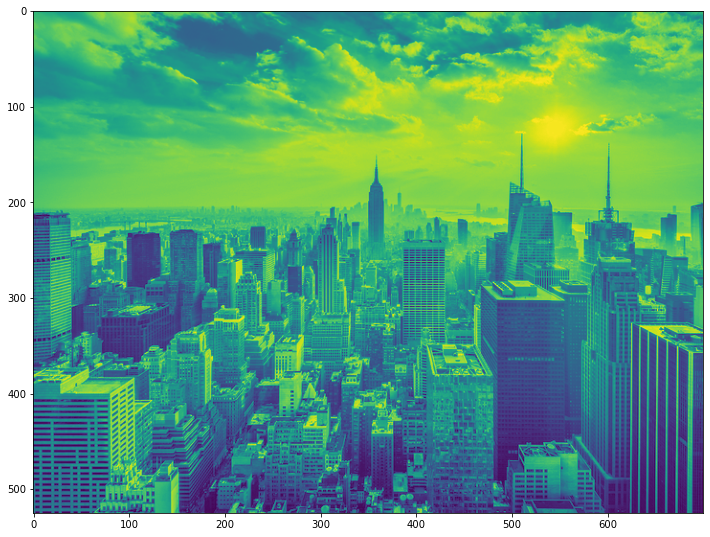

In [106]:
plt.figure(figsize=(12,12))
plt.imshow(img_arr)
plt.clim(0,255)